# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd /home/jovyan/dea_intertidal/dea-intertidal/

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
# pip install -r requirements.in --quiet

### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

## Setup


### Set analysis parameters

In [4]:
# Set study area and config
study_area = "Lake Tyers Vic"
# config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '1215'
config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2018"  # Start date for analysis
end_date = "2020"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*
> *Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance*

In [5]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Intertidal elevation

In [6]:
# Model elevation for each pixel
ds, freq, corr, tide_m = elevation(
    study_area=study_area,
    start_date=start_date,
    end_date=end_date,
    config_path=config_path,
)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40005,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:35695,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38121/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:39653,


2023-05-08 05:24:02 INFO Study area testing: Loaded custom study area
2023-05-08 05:24:02 INFO Study area testing: Loading satellite data
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-05-08 05:31:53 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 477/477 [01:00<00:00,  7.84it/s]
2023-05-08 05:33:38 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-05-08 05:34:02 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-05-08 05:36:12 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 12160304 to 166722 (1.37%)


100%|██████████| 114/114 [03:09<00:00,  1.66s/it]
2023-05-08 05:39:36 INFO Study area testing: Modelling intertidal elevation and confidence


Processing elevation_low
Processing elevation
Processing elevation_high


2023-05-08 05:39:37 INFO Study area testing: Successfully completed intertidal elevation modelling


### Intertidal extents

#### Always/sometimes/never wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [ ]:
ds['extents'], wet_ext = extents(ds.elevation, freq, corr)

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds['exposure'], tide_cq = exposure(ds.elevation, all_timerange)

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
(ds['lat'], 
 ds['hat'], 
 ds['lot'], 
 ds['hot'], 
 ds['spread'], 
 ds['offset_lowtide'],
 ds['offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [ ]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.offset_hightide,
                                         offset_lowtide=ds.offset_lowtide,
                                         distance=250)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
# Set up figure
fig = plt.figure(figsize=(10, 25))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 2)
ax3 = fig.add_subplot(6, 2, 3)
ax4 = fig.add_subplot(6, 2, 4)
ax5 = fig.add_subplot(6, 2, 5)
ax6 = fig.add_subplot(6, 2, 6)
ax7 = fig.add_subplot(6, 2, 7)
ax8 = fig.add_subplot(6, 2, 8)
ax9 = fig.add_subplot(6, 2, 9)
ax10 = fig.add_subplot(6, 2, 10)
ax11 = fig.add_subplot(6, 2, 11)
ax12 = fig.add_subplot(6, 2, 12)

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(ax=ax1, cmap="viridis", interpolation="bilinear")
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax1, interpolation="bilinear"
)
ax1.set_title("Elevation (metres AMSL)")

# Plot Exposure
ds["exposure"].where(ds["exposure"] > 0).plot.imshow(
    ax=ax2, cmap="RdYlGn", levels=np.arange(0, 100, 1)
)
ax2.set_title("Exposure-% of time")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax3)
ax3.set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["spread"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax4, vmin=0, vmax=100, cmap="magma", cbar_kwargs={"label": "% spread"}
)
ax4.set_title("Observation Spread")

# Plot the high-tide offset
ds["offset_hightide"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax5, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% high tide offset"}
)
ax5.set_title("High-tide offset")

# Plot the low-tide offset
ds["offset_lowtide"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax6, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% low tide offset"}
)
ax6.set_title("Low-tide offset")

# Plot the LAT
ds["lat"].where(ds["extents"] != 2).plot.imshow(
    ax=ax7, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax7.set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["lot"].where(ds["extents"] != 2).plot.imshow(
    ax=ax8, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax8.set_title("Lowest Observed Tide")

# Plot the HAT
ds["hat"].where(ds["extents"] != 2).plot.imshow(
    ax=ax9, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax9.set_title("Highest Astronomical Tide")

# Plot the HOT
ds["hot"].where(ds["extents"] != 2).plot.imshow(
    ax=ax10, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax10.set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax11.set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax11,
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax11, zorder=1)
ax11.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax11.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax12.set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax12,
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax12, zorder=1)
ax12.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax12.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

fig.tight_layout()
plt.show()

In [ ]:
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).odc.write_cog('testing.tif')

## Export layers

In [ ]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = "testing"

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"data/interim/{study_area}_{start_date}_{end_date}")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")

In [7]:
import datacube
import xarray as xr
from skimage.measure import label, regionprops
from skimage.morphology import (binary_erosion, disk)

In [8]:
dc = datacube.Datacube(app='ocean_masking')

In [9]:
## Testing ocean/land water body separation
## https://github.com/GeoscienceAustralia/dea-coastlines/blob/develop/coastlines/vector.py#L188-L198

def ocean_masking(ds, ocean_da, connectivity=1, dilation=None):
    """
    Identifies ocean by selecting regions of water that overlap
    with ocean pixels. This region can be optionally dilated to
    ensure that the sub-pixel algorithm has pixels on either side
    of the water index threshold.
    Parameters:
    -----------
    ds : xarray.DataArray
        An array containing True for land pixels, and False for water.
        This can be obtained by thresholding a water index
        array (e.g. MNDWI < 0).
    ocean_da : xarray.DataArray
        A supplementary static dataset used to separate ocean waters
        from other inland water. The array should contain values of 1
        for high certainty ocean pixels, and 0 for all other pixels
        (land, inland water etc). For Australia, we use the  Geodata
        100K coastline dataset, rasterized as the "geodata_coast_100k"
        product on the DEA datacube.
    connectivity : integer, optional
        An integer passed to the 'connectivity' parameter of the
        `skimage.measure.label` function.
    dilation : integer, optional
        The number of pixels to dilate ocean pixels to ensure than
        adequate land pixels are included for subpixel waterline
        extraction. Defaults to None.
    Returns:
    --------
    ocean_mask : xarray.DataArray
        An array containing the a mask consisting of identified ocean
        pixels as True.
    """

    # Update `ocean_da` to mask out any pixels that are land in `ds` too
    ocean_da = ocean_da & (ds != 1)

    # First, break all time array into unique, discrete regions/blobs.
    # Fill NaN with 1 so it is treated as a background pixel
    blobs = xr.apply_ufunc(label, ds.fillna(1), 1, False, connectivity)

    # For each unique region/blob, use region properties to determine
    # whether it overlaps with a water feature from `water_mask`. If
    # it does, then it is considered to be directly connected with the
    # ocean; if not, then it is an inland waterbody.
    ocean_mask = blobs.isin(
        [i.label for i in regionprops(blobs.values, ocean_da.values) if i.max_intensity]
    )

    # Dilate mask so that we include land pixels on the inland side
    # of each shoreline to ensure contour extraction accurately
    # seperates land and water spectra
    if dilation:
        ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

    return ocean_mask


In [18]:
## Calculate extent classes
'''
Classify coastal ecosystems into broad classes based 
on their respective patterns of wetting frequency,
relationship to tidal inundation and proximity to
the ocean.

Parameters:
-----------
dem : xarray.DataArray
    An xarray.DataArray of the final intertidal DEM, generated 
    during the intertidal.elevation workflow
freq : xarray.DataArray
    An xarray.DataArray of the NDWI frequency layer summarising the 
    frequency of wetness per pixel for any given time-series, 
    generated during the intertidal.elevation workflow
corr : xarray.DataArray
    An xarray.DataArray of the correlation between pixel NDWI values
    and the tide-height, generated during the intertidal.elevation workflow
ocean_da : xarray.DataArray
    A supplementary static dataset used to separate ocean waters
    from other inland water. The array should contain values of 1
    for high certainty ocean pixels, and 0 for all other pixels
    (land, inland water etc). For Australia, we use the  Geodata
    100K coastline dataset, rasterized as the "geodata_coast_100k"
    product on the DEA datacube.
    
Returns:
--------
extents: xarray.DataArray
    A binary xarray.DataArray depicting intertidal (0), tidal-wet (1),
    nontidal-wet (2), intermittently, non-tidal wet (3) and dry (4) coastal extents.
Notes:
------
Classes are defined as follows:
0: Intertidal
    Frequency of pixel wetness (`freq`) is > 0.01 and < 0.99
    The correlation (`corr`) between `freq` and tide-heights is > 0.2
1: Wet tidal
    Frequency of pixel wetness (`freq`) is > 0.95
    Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
    and `corr` to tide > 0.1. This captures intertidal pixels buffered
    out by the `corr` threshold of 0.2 (default)
    Pixels are located offshore, within 10 pixels of known ocean, as defined
    by the Geodata 100k coastline dataset (`ocean_da`)
2: Wet nontidal
    Frequency of pixel wetness (`freq`) is > 0.95
    Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
    and `corr` to tide > 0.1. This captures intertidal pixels buffered
    out by the `corr` threshold of 0.2 (default)
    Pixels are located onshore, more than 10 pixels from known ocean, as defined
    by the Geodata 100k coastline dataset (`ocean_da`)
3: Intermittently wet nontidal
    Pixels with wetting `freq` between 0.95 and 0.05 and
    `corr` of `freq` to tide is < 0.1    
4: Dry
    Pixels with wettness `freq` < 0.05
    Includes intermittently dry pixels with wetness frequency < 0.5 and > 0.05
    and `corr` to tide > 0.1 to capture intertidal pixels buffered
    out by the `corr` threshold of 0.2
'''
## Isolate intertidal class
intertidal = freq.where(ds.elevation.notnull())

## Isolate non-intertidal class
wetdry = freq.where(ds.elevation.isnull())

## Separate non-intertidal areas into always wet and always dry classes
wet = wetdry.where(wetdry >= 0.95, drop=True)
dry = wetdry.where((wetdry <= 0.05), drop=True)

## Identify intermittent tidal classes 
intermittent_tidal_wet = freq.where(
                                    (wetdry < 0.95)
                                    & (wetdry >= 0.5) 
                                    & (corr > 0.1) 
                                    # & (freq > 0.5)
                                   )

intermittent_tidal_dry = freq.where(
                                    (wetdry < 0.5)
                                    & (wetdry > 0.05) 
                                    & (corr > 0.1) 
                                    # & (freq < 0.5)
                                    )

## Identify intermittent non-tidal class
intermittent_nontidal = freq.where(
                                   (wetdry < 0.95)
                                   & (wetdry > 0.05) 
                                   & (corr <= 0.1)
                                   )

## Relabel pixels in the classes. 
## Add intermittent tidal wet/dry to the always wet/dry classes
intertidal = intertidal.where(intertidal.isnull(), 0)
wet = wet.where(wet.isnull(), 1)
dry = dry.where(dry.isnull(), 4)
intermittent_tidal_wet = intermittent_tidal_wet.where(intermittent_tidal_wet.isnull(), 1)
intermittent_tidal_dry = intermittent_tidal_dry.where(intermittent_tidal_dry.isnull(), 4)                    
intermittent_nontidal = intermittent_nontidal.where(intermittent_nontidal.isnull(), 3)

## Combine classes
extents = intertidal.combine_first(wet)
extents = extents.combine_first(dry)
extents = extents.combine_first(intermittent_tidal_wet)
extents = extents.combine_first(intermittent_tidal_dry)
extents = extents.combine_first(intermittent_nontidal)

## Separate the onshore from offshore 'always wet' class

## Mask all pixels in `intext` as `always_wet` or 'other'
landwater=extents.where(extents != 1, False)

## Use the ocean_masking functionality from 
## https://github.com/GeoscienceAustralia/dea-coastlines/blob/develop/coastlines/vector.py

## Load the Geodata 100k coastline layer to use as the seawater mask

# Load Geodata 100K coastal layer to use to separate ocean waters from
# other inland waters. This product has values of 0 for ocean waters,
# and values of 1 and 2 for mainland/island pixels. We extract ocean
# pixels (value 0), then erode these by 10 pixels to ensure we only
# use high certainty deeper water ocean regions for identifying ocean
# pixels in our satellite imagery. If no Geodata data exists (e.g.
# over remote ocean waters, use an all True array to represent ocean.
try:    
    geodata_da = dc.load(product = 'geodata_coast_100k',
                        like=landwater.odc.geobox.compat
                      ).land.squeeze('time')
    ocean_da = xr.apply_ufunc(binary_erosion, geodata_da == 0, disk(10))
except AttributeError:
    ocean_da = odc.geo.xr.xr_zeros(landwater.odc.geobox) == 0
# except ValueError:  # Temporary workaround for no geodata access for tests from https://github.com/GeoscienceAustralia/dea-coastlines/blob/develop/coastlines/vector.py
#     ocean_da = xr.apply_ufunc(binary_erosion, all_time_20==0, disk(20))

## Applying ocean_masking function
ocean_mask = ocean_masking(landwater, ocean_da)

## distinguish wet tidal from non-tidal pixels
wet_nontidal = extents.where((extents==1) & (ocean_mask == False))#, drop=True) ## Weird artefacts when drop=True
wet_tidal = extents.where((extents==1) & (ocean_mask == True), drop=True)

## Relabel pixels
wet_nontidal = wet_nontidal.where(wet_nontidal.isnull(), 2)
wet_tidal = wet_tidal.where(wet_tidal.isnull(), 1)

## remove `wet` pixels from int_ext to replace with the tidal and non tidal wet classes
extents = extents.where(extents != 1, np.nan)

## combine wet tidal and nontidal variables back into int_ext
extents = extents.combine_first(wet_nontidal)
extents = extents.combine_first(wet_tidal)

extents.plot(cmap='magma')
plt.title('Intertidal:0, Wet-tidal:1, Wet-nontidal:2, Intermittent wet nontidal:3, Dry:4')

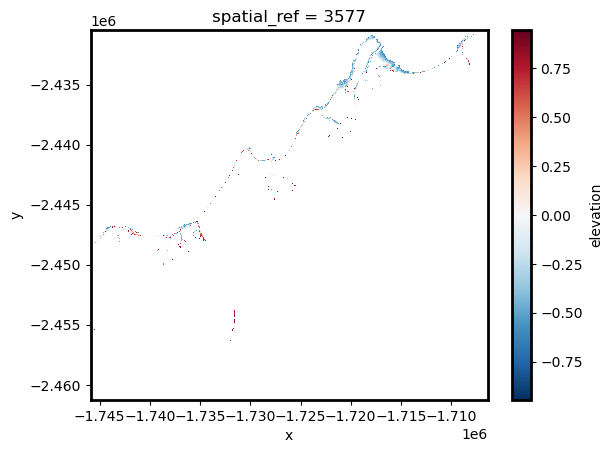

In [11]:
ds.elevation.plot()

In [ ]:
# ## Calculate extent classes - Working draft

# ## Isolate intertidal areas
# testint = freq.where(ds.elevation.notnull())

# ## Isolate non-intertidal areas
# wetdry = freq.where(ds.elevation.isnull())

# ## Separate non-intertidal areas into always wet and always dry classes
# testwet = wetdry.where(wetdry >= 0.95, drop=True)
# testdry = wetdry.where((wetdry <= 0.05), drop=True)

# ## Relabel pixels in the intertidal, always wet and always dry classes
# testint = testint.where(testint.isnull(), 0)
# testwet = testwet.where(testwet.isnull(), 1)
# testdry = testdry.where(testdry.isnull(), 2)

# ## Combine intertidal, always wet and always dryclasses
# intext = testint.combine_first(testwet)
# intext = intext.combine_first(testdry)

# ## Identify intermittent tidal classes 
# intermittent_tidal_wet = freq.where((intext.isnull()) & (corr > 0.1) & (freq>0.5))
# intermittent_tidal_dry = freq.where((intext.isnull()) & (corr > 0.1) & (freq<0.5))

# ## Identify intermittent non-tidal class
# intermittent_nontidal = freq.where((intext.isnull()) & (corr < 0.1))

# intermittent_tidal_wet = intermittent_tidal_wet.where(intermittent_tidal_wet.isnull(), 1)
# intermittent_tidal_dry = intermittent_tidal_dry.where(intermittent_tidal_dry.isnull(), 2)                    
# intermittent_nontidal = intermittent_nontidal.where(intermittent_nontidal.isnull(), 3)

# int_ext = intext.combine_first(intermittent_tidal_wet)
# int_ext = int_ext.combine_first(intermittent_tidal_dry)
# int_ext = int_ext.combine_first(intermittent_nontidal)



# int_ext.plot()
# plt.title('Intertidal:0, Wet:1, Dry:2, Intermittent nontidal:3')#, Intermittent tidal (wet):4, Intermittent tidal (dry):5')

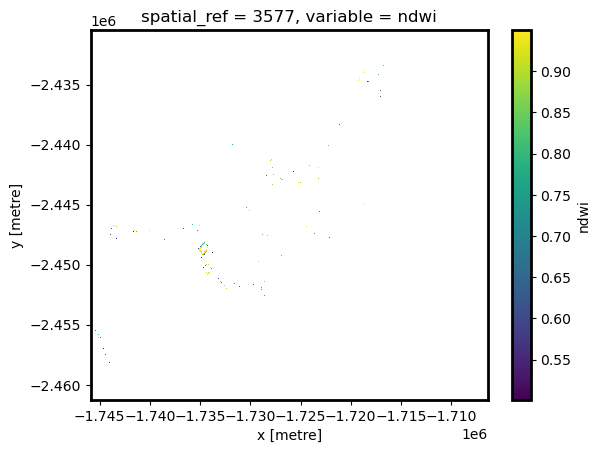

In [12]:
intermittent_tidal_wet = freq.where(
                                    (wetdry < 0.95)
                                    & (wetdry > 0.05) 
                                    & (corr > 0.1) 
                                    & (freq > 0.5)
                                   )

intermittent_tidal_wet.plot()

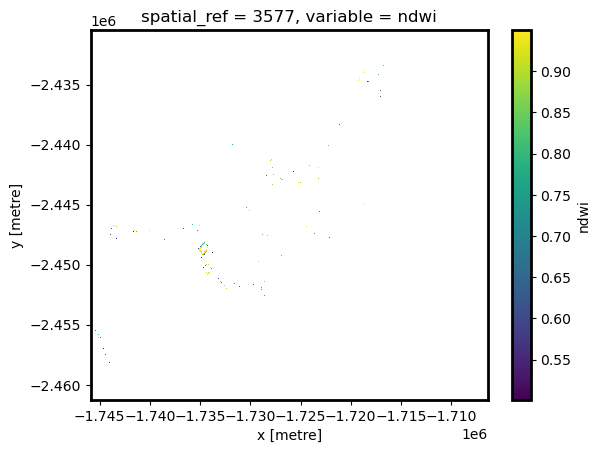

In [13]:
intermittent_tidal_wet2 = freq.where(
                                    (wetdry < 0.95)
                                    & (wetdry > 0.5) 
                                    & (corr > 0.1) 
                                    # & (freq > 0.5)
                                   )

intermittent_tidal_wet2.plot()

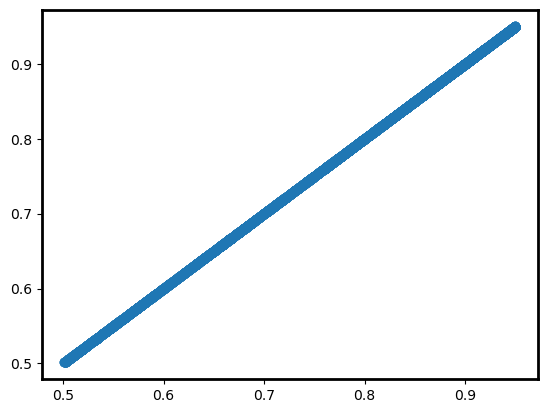

In [14]:
plt.scatter(intermittent_tidal_wet, intermittent_tidal_wet2)